# Data Analysis

This notebook provides code to analyze data collected using sensors deployed during the Indaba 2019 maker session

We have deployed the following sensors
1. Ambient Temperature
1. Relative Humidity


The sensors are connected to a [Nucleo F446re](https://os.mbed.com/platforms/ST-Nucleo-F446RE/) development board running code contained in this [repo](https://github.com/ciiram/indaba-maker-session-2019).

The data collected from the sensors has been stored on an InfluxDB on your machine. We will connect to this DB, visualise the data and use Gaussian processes to interpolate simulated missing values and make predictions.

## Requirements

1. [pandas](https://pandas.pydata.org/)
1. [matplotlib](https://matplotlib.org/)
1. [GPy](https://sheffieldml.github.io/GPy/)
1. [influxdb](https://www.influxdata.com/blog/getting-started-python-influxdb/)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from pandas.io.json import json_normalize

from influxdb import InfluxDBClient
from datetime import datetime, timedelta

## Plots of Ambient Temperature 

We will examine plots of ambient temperature recorded by our device. First we connect to our database to access the data stored.

In [29]:
client = InfluxDBClient(host='localhost', port=8086)
client.switch_database('indaba_session')

Let us try a few queries

In [30]:
# Get the last entry

result = client.query('select last("Temperature") from "Indaba Session"')
print(result.raw)

{'statement_id': 0, 'series': [{'name': 'Indaba Session', 'columns': ['time', 'last'], 'values': [['2019-08-13T10:32:05.997741056Z', 19]]}]}


In [36]:
# Get the entries from the last hour

result = client.query('select * from "Indaba Session" where time > now() - 3h')
print(result.raw)

{'statement_id': 0, 'series': [{'name': 'Indaba Session', 'columns': ['time', 'Relative Humidity', 'Temperature', 'data_rate', 'rssi', 'sensor', 'snr'], 'values': [['2019-08-13T09:51:12.862162944Z', 67, 19, 'SF12BW125', -106, 'dev-01', 4.5], ['2019-08-13T09:52:18.947958016Z', 66, 19, 'SF12BW125', -106, 'dev-01', 3.5], ['2019-08-13T09:54:31.183408128Z', 66, 19, 'SF12BW125', -105, 'dev-01', 4], ['2019-08-13T09:55:40.328742912Z', 66, 19, 'SF12BW125', -106, 'dev-01', 4.8], ['2019-08-13T09:56:46.411796992Z', 66, 19, 'SF12BW125', -104, 'dev-01', 3.2], ['2019-08-13T09:57:52.53283584Z', 66, 19, 'SF12BW125', -105, 'dev-01', 4], ['2019-08-13T09:59:01.675297024Z', 67, 19, 'SF12BW125', -105, 'dev-01', 3.8], ['2019-08-13T10:01:21.906335232Z', 67, 19, 'SF12BW125', -105, 'dev-01', 4.2], ['2019-08-13T10:02:28.003032064Z', 67, 19, 'SF12BW125', -108, 'dev-01', 3.5], ['2019-08-13T10:04:45.237918976Z', 67, 19, 'SF12BW125', -103, 'dev-01', 4.2], ['2019-08-13T10:05:57.406553856Z', 67, 19, 'SF12BW125', -103,

In [38]:
result_list = list(result.get_points())

# turn to pandas dataframe
df = pd.DataFrame(result_list)

# make time a datetime object
df[['time']] = df[['time']].apply(pd.to_datetime)

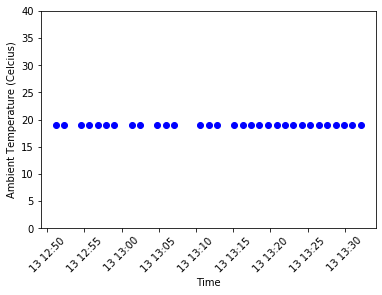

In [39]:
%matplotlib inline
plt.figure()
plt.plot(df['time'] + timedelta(hours=3), df['Temperature'], 'bo');
plt.xticks(rotation=45);
plt.ylim([0, 40]);
plt.xlabel('Time');
plt.ylabel('Ambient Temperature (Celcius)');

## Modelling

We will experiment with curve fitting using the data we have collected. We will fit Gaussian process models with various kernels and assess the fits. We will work with the temperature data.

In [42]:

sensor_groups = df.groupby('sensor')
[grp for name, grp in sensor_groups]

[                                  time  Relative Humidity  Temperature  \
 0  2019-08-13 09:51:12.862162944+00:00                 67           19   
 1  2019-08-13 09:52:18.947958016+00:00                 66           19   
 2  2019-08-13 09:54:31.183408128+00:00                 66           19   
 3  2019-08-13 09:55:40.328742912+00:00                 66           19   
 4  2019-08-13 09:56:46.411796992+00:00                 66           19   
 5  2019-08-13 09:57:52.532835840+00:00                 66           19   
 6  2019-08-13 09:59:01.675297024+00:00                 67           19   
 7  2019-08-13 10:01:21.906335232+00:00                 67           19   
 8  2019-08-13 10:02:28.003032064+00:00                 67           19   
 9  2019-08-13 10:04:45.237918976+00:00                 67           19   
 10 2019-08-13 10:05:57.406553856+00:00                 67           19   
 11 2019-08-13 10:07:03.451276032+00:00                 67           19   
 12 2019-08-13 10:10:34.8

In [43]:
import GPy
import numpy as np
from IPython.display import display

#prepare the data
sensor_groups = df.groupby('sensor')

# get data corresponding to device 1
dev_01 = [grp for name, grp in sensor_groups][0] 
dev_01 = dev_01.sort_values(by='time');

#get the temperature and time
temperature = dev_01.values[:,2]
time_day = [value.timestamp() for value in dev_01.values[:,0]] # get the timestamps
time_day = np.array(time_day)

#normalize to days
time_day = time_day - min(time_day)
time_day /= (24 * 60 * 60)

# get the first 7 days
temperature = temperature[time_day < 7]
time_day = time_day[time_day < 7]


We visualise the data

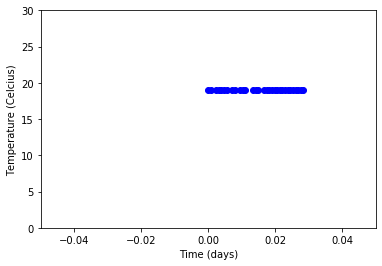

In [50]:
plt.figure()
plt.plot(time_day, temperature, 'bo')
plt.xlim([-.05,.05])
plt.ylim([0, 30])
plt.xlabel('Time (days)');
plt.ylabel('Temperature (Celcius)');

We fit a Gaussian process with a radial basis function kernel. (If the optimization fails, simply restart it.)

In [51]:
#RBF Kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(time_day[:, None],temperature[:, None],kernel)
m.optimize_restarts(num_restarts = 10)
display(m)

Optimization restart 1/10, f = -242.65411266511651
Optimization restart 2/10, f = -242.6329723982657
Optimization restart 3/10, f = -242.61292889788308
Optimization restart 4/10, f = -242.637584789048
Optimization restart 5/10, f = -242.66143804844612
Optimization restart 6/10, f = -242.6234860370876
Optimization restart 7/10, f = -242.65545746676884
Optimization restart 8/10, f = -242.5578630424343
Optimization restart 9/10, f = -242.6529363407635
Optimization restart 10/10, f = -242.62256413214627


GP_regression.,value,constraints,priors
rbf.variance,359.04490222179635,+ve,
rbf.lengthscale,438764.2239345855,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


Let's plot the fit

<Figure size 432x288 with 0 Axes>

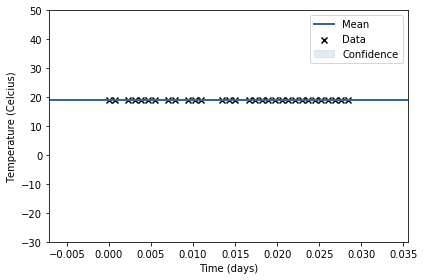

In [52]:
plt.figure()
m.plot();
plt.ylim([-30, 50]);
plt.xlabel('Time (days)');
plt.ylabel('Temperature (Celcius)');

The fit with the RBF kernel does not do a good job of filling in the missing data. In the region without data, the posterior fit is similar to the prior which results in the interpolant passing through zero. It is never that cold in Nyeri!

We now try a periodic kernel on the same data which takes into account the observation that temperature variations are periodic. (If the optimization fails, simply restart it.)

In [53]:
periodic_kernel = GPy.kern.PeriodicMatern32(input_dim=1, variance=1., lengthscale=1., period=1.)
m = GPy.models.GPRegression(time_day[:, None],temperature[:, None], periodic_kernel)
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -241.13298150791442
Optimization restart 2/10, f = -233.81062092389828
Optimization restart 3/10, f = -231.51853357095058
Optimization restart 4/10, f = -111.33586929477599
Optimization restart 5/10, f = 135.26470288488278
Optimization restart 6/10, f = -239.70793991972926
Optimization restart 7/10, f = -235.04543162168414
Optimization restart 8/10, f = -118.68600963563594
Optimization restart 9/10, f = -229.7879982859082


 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/GPy/kern/src/periodic.py:196: RuntimeWarning:overflow encountered in true_divide
 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/GPy/kern/src/periodic.py:40: RuntimeWarning:invalid value encountered in multiply
 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/GPy/kern/src/periodic.py:40: RuntimeWarning:invalid value encountered in cos


Optimization restart 10/10, f = -238.71348593821634


 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/GPy/likelihoods/gaussian.py:119: RuntimeWarning:invalid value encountered in sqrt


<Figure size 432x288 with 0 Axes>

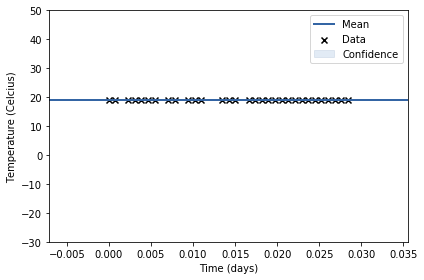

In [54]:
plt.figure()
m.plot();
plt.ylim([-30, 50]);
plt.xlabel('Time (days)');
plt.ylabel('Temperature (Celcius)');

The fit is still not good. The prior with a zero mean does not fit the data.
We need to add bias. (If the optimization fails, simply restart it.)



 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/20, f = -240.20907376506017
Optimization restart 2/20, f = -242.66167085662684
Optimization restart 3/20, f = -242.66167698604374
Optimization restart 4/20, f = -242.6616703174318
Optimization restart 5/20, f = -242.66166049951534
Optimization restart 6/20, f = -242.66166758954503
Optimization restart 7/20, f = -242.66167662251868
Optimization restart 8/20, f = -242.66167405024416
Optimization restart 9/20, f = -242.66167599525315


 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/GPy/kern/src/periodic.py:212: RuntimeWarning:overflow encountered in multiply
 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/GPy/kern/src/periodic.py:204: RuntimeWarning:overflow encountered in square
 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/GPy/kern/src/periodic.py:212: RuntimeWarning:overflow encountered in true_divide


Optimization restart 10/20, f = -242.6616719168797
Optimization restart 11/20, f = -242.66167310859407
Optimization restart 12/20, f = -242.6616731791594
Optimization restart 13/20, f = -242.66167255269093
Optimization restart 14/20, f = -242.66167049827848
Optimization restart 15/20, f = -242.66166628999824


 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /home/ciira/Documents/Research/MBED/indaba-maker-session-2019/ttn/lib/python3.7/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 16/20, f = -242.65482281165842
Optimization restart 17/20, f = -242.66167108181435
Optimization restart 18/20, f = -242.66167693638488
Optimization restart 19/20, f = -242.66144200979534
Optimization restart 20/20, f = -242.66164363198186


<Figure size 432x288 with 0 Axes>

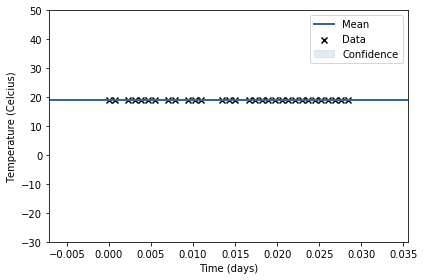

In [55]:
kernel_bias = GPy.kern.Bias(1)

m = GPy.models.GPRegression(time_day[:, None],temperature[:, None], periodic_kernel + kernel_bias)
m.optimize_restarts(num_restarts = 20)

# plot the fit
plt.figure()
m.plot();
plt.ylim([-30, 50]);
plt.xlabel('Time (days)');
plt.ylabel('Temperature (Celcius)');

This is a much better fit and the predicted values in the region with missing data is quite reasonable.
